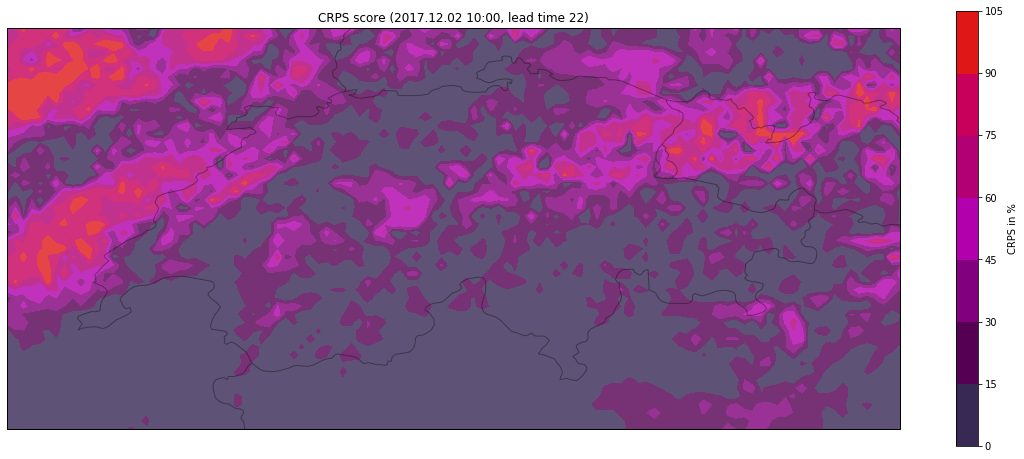

In [1]:
%matplotlib inline

import os
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cft
import pandas as pd
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

filepath = os.path.join("..", "local_playground", "persistence_CRPS_201712-201802_only12_lt22.pkl")
outpath = os.path.join("..", "local_playground", "map_example.png")
time = pd.Timestamp("20171202 10")  # Set to a pandas Timestamp, or to None to get the mean over all times. 

## import data
df = pd.read_pickle(filepath).reset_index(["lat", "lon"])
lon = np.unique(df["lon"])
lat = np.unique(df["lat"])
CRPS = df.iloc[(df.time == time).values].CRPS.values.reshape((len(lat), len(lon))) if time else np.transpose(
    df.groupby(["lon", "lat"]).mean().values.reshape((len(lon), len(lat))))

## make the plot
borders = cft.NaturalEarthFeature("cultural", "admin_0_countries", "10m")
fig = plt.figure(figsize=(20, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([min(lon), max(lon), min(lat), max(lat)])
ax.add_feature(borders, facecolor=(1, 1, 1), alpha=.2, linewidth=1, edgecolor="black")
cs = plt.contourf(lon, lat, CRPS, transform=ccrs.PlateCarree(), 
                  colors=["#372854", "#560054", "#81007d", "#b200ac", "#b20074", "#c8005b", "#df1717", "#ff0000"])
cbar = plt.colorbar(cs)
cbar.ax.set_ylabel("CRPS in %")
plt.title("CRPS score (" + (time.strftime("%Y.%m.%d %H:%M") if time else "mean") + ", lead time 22)")

## save and show the plot
plt.savefig(outpath, dpi=100, format="png")
plt.show()
plt.close(1)